## Analyzing CIA Factbook Data Using SQL
We are using data from the [CIA World Factbook](https://www.cia.gov/library/publications/the-world-factbook/) which contains statistics about all of the countries on Earth.  The data contains information on demographics such as:
* `population` - as of 2015
* `population_growth` - The annual population growth rate, as a percentage
* `area` - total land and water area

Connect to the database file

In [1]:
%%capture
%load_ext sql
%sql sqlite:///factbook.db

In [2]:
from sqlalchemy import  create_engine
 
engine = create_engine('sqlite:///factbook.db')
engine.connect()
print(engine)

Engine(sqlite:///factbook.db)


In [3]:
%%sql
SELECT * FROM sqlite_master WHERE type='table';

 * sqlite:///factbook.db
Done.


type,name,tbl_name,rootpage,sql
table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, ""code"" varchar(255) NOT NULL, ""name"" varchar(255) NOT NULL, ""area"" integer, ""area_land"" integer, ""area_water"" integer, ""population"" integer, ""population_growth"" float, ""birth_rate"" float, ""death_rate"" float, ""migration_rate"" float)"


In [4]:
%%sql
SELECT * FROM facts limit 5;

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
2,al,Albania,28748,27398,1350,3029278,0.3,12.92,6.58,3.3
3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.0
5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


The table above is the first few rows of the `facts` table.  Here is the description of some of the columns:
* `name` - Name of the country
* `area` - Total land and sea area of the country
* `population` - Country's population
* `population_growth` - Country's population growth as a percentage
* `birth_rate` - Country's birth rate, number of births a year per 1,000 people.
* `death_rate` - Counntry's death rate, number of deaths a year per 1,000 people
* `area_land` - Country's land area in square kilometers
* `area_water` - Country's water area in square kilometers

Let us find the minimum and maximum population and population growth below

In [5]:
%%sql
SELECT MIN(population) as pop_min, MAX(population) as pop_max,
MIN(population_growth) as min_pop_growth, MAX(population_growth) as max_pop_growth FROM facts;

 * sqlite:///factbook.db
Done.


pop_min,pop_max,min_pop_growth,max_pop_growth
0,7256490011,0.0,4.02


The population minimum of zero and the population maximum of 7256490011 stick out, let us look at these more closely

In [6]:
%%sql
SELECT * FROM facts
WHERE population ==(SELECT MIN(population) FROM facts);

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
250,ay,Antarctica,None,280000,None,0,None,None,None,None


In [7]:
%%sql
SELECT * FROM facts
WHERE population == (SELECT MAX(population) FROM facts);

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None


We can see here that the table contains a row for the whole world.

From the [Antarctica page](https://www.cia.gov/library/publications/the-world-factbook/geos/ay.html) of the CIA World Factbook we find:

'no indigenous inhabitants, but there are both permanent and summer-only staffed research stations

note: 53 countries have signed the 1959 Antarctic Treaty; 30 of those operate through their National Antarctic Program a number of seasonal-only (summer) and year-round research stations on the continent and its nearby islands south of 60 degrees south latitude (the region covered by the Antarctic Treaty); the population engaging in and supporting science or managing and protecting the Antarctic region varies from approximately 4,400 in summer to 1,100 in winter; in addition, approximately 1,000 personnel, including ship's crew and scientists doing onboard research, are present in the waters of the treaty region'

####  Average values for population and area

In [8]:
%%sql
SELECT AVG(population) as avg_pop, AVG(area) as avg_area FROM facts
WHERE name <> 'World';

 * sqlite:///factbook.db
Done.


avg_pop,avg_area
32242666.56846473,555093.546184739


In [9]:
%%sql
SELECT * FROM facts
WHERE population > (SELECT AVG(population) FROM facts)
AND area < (SELECT AVG(area) FROM facts);

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
14,bg,Bangladesh,148460,130170,18290,168957745,1.6,21.14,5.61,0.46
65,gm,Germany,357022,348672,8350,80854408,0.17,8.47,11.42,1.24
85,ja,Japan,377915,364485,13430,126919659,0.16,7.93,9.51,0.0
138,rp,Philippines,300000,298170,1830,100998376,1.61,24.27,6.11,2.09
173,th,Thailand,513120,510890,2230,67976405,0.34,11.19,7.8,0.0
185,uk,United Kingdom,243610,241930,1680,64088222,0.54,12.17,9.35,2.54
192,vm,Vietnam,331210,310070,21140,94348835,0.97,15.96,5.93,0.3


#### Data Exploration
* Which countries have the highest ratios of water to land? Which countries have more water than land?
* Which countries will add the most people to their population next year?
* Which countries have a higher death rate than birth rate?
##### Water to Land Ratios

In [10]:
%%sql
SELECT name, area_land, area_water
FROM facts
WHERE area_water>area_land
ORDER BY area_water
DESC;

 * sqlite:///factbook.db
Done.


name,area_land,area_water
British Indian Ocean Territory,60,54340
Virgin Islands,346,1564


In [11]:
%%sql
SELECT name, area, area_land, area_water, 
ROUND((CAST(area_water as float)/area_land),3) as ratio_water_to_land, 
ROUND(((CAST(area_water as float)/area)*100),3) as pct_water
FROM facts
WHERE area_water <>0
ORDER BY ratio_water_to_land
DESC
LIMIT 5;

 * sqlite:///factbook.db
Done.


name,area,area_land,area_water,ratio_water_to_land,pct_water
British Indian Ocean Territory,54400,60,54340,905.667,99.89
Virgin Islands,1910,346,1564,4.52,81.885
Puerto Rico,13791,8870,4921,0.555,35.683
"Bahamas, The",13880,10010,3870,0.387,27.882
Guinea-Bissau,36125,28120,8005,0.285,22.159


The British Indian Ocean Territory and the Virgin Islands are the two countries with more water area than land area.  They are 99.9% and 81.9% water, respectively.
Puerto Rico comes in at 3rd with 35.7% water and a .56 water to land ratio.  The Bahamas and Guinea-Bissau are top four and five for percent water with 27.9% and 22.2% respectively.

##### Population growth for next year
According to the [CIA World Factbook](https://www.cia.gov/library/publications/the-world-factbook/fields/344rank.html) the data for populaation growth in the table takes into account the death and migrations rates.<br>
'Population growth rate compares the average annual percent change in populations, resulting from a surplus (or deficit) of births over deaths and the balance of migrants entering and leaving a country. The rate may be positive or negative.'<br>
We will see which countries have the highest population growth rate which is represented as a percentage.  Then we will look at the predicted total number of people added to the population.

In [27]:
%%sql pop_growth <<
SELECT name, population, population_growth,
ROUND(((population_growth/100)*population),0) as people_added, 
death_rate, migration_rate 
FROM facts
ORDER BY population_growth
DESC
LIMIT 10;

 * sqlite:///factbook.db
Done.
Returning data to local variable pop_growth


In [28]:
pop_growth = pop_growth.DataFrame()
pop_growth.head()

,name,population,population_growth,people_added,death_rate,migration_rate
0,South Sudan,12042910,4.02,484125.0,8.18,11.47
1,Malawi,17964697,3.32,596428.0,8.41,0.00
2,Burundi,10742276,3.28,352347.0,9.27,0.00
3,Niger,18045729,3.25,586486.0,12.42,0.56
4,Uganda,37101745,3.24,1202097.0,10.69,0.74


In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
pop_growth.set_index('name', drop=True, inplace=True)

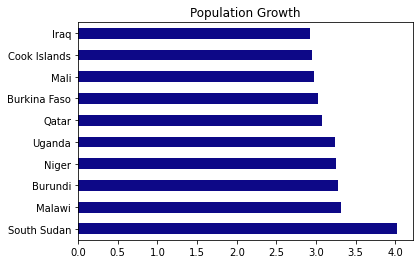

In [32]:
pop_growth['population_growth'].plot.barh(title = 'Population Growth',colormap=plt.cm.plasma)
plt.ylabel('')
plt.show()

In [50]:
%%sql people_added <<
SELECT name, population, population_growth, 
ROUND(((population_growth/100)*population),0) as people_added,
death_rate, migration_rate 
FROM facts
ORDER BY people_added
DESC
LIMIT 11;

 * sqlite:///factbook.db
Done.
Returning data to local variable people_added


In [51]:
people_added = people_added.DataFrame()
people_added.head()

,name,population,population_growth,people_added,death_rate,migration_rate
0,World,7256490011,1.08,78370092.0,7.80,NaN
1,India,1251695584,1.22,15270686.0,7.32,0.04
2,China,1367485388,0.45,6153684.0,7.53,0.44
3,Nigeria,181562056,2.45,4448270.0,12.90,0.22
4,Pakistan,199085847,1.46,2906653.0,6.49,1.54


In [52]:
#drop world for plot
people_added_mod = people_added[1:].copy()
people_added_mod.head()

,name,population,population_growth,people_added,death_rate,migration_rate
1,India,1251695584,1.22,15270686.0,7.32,0.04
2,China,1367485388,0.45,6153684.0,7.53,0.44
3,Nigeria,181562056,2.45,4448270.0,12.90,0.22
4,Pakistan,199085847,1.46,2906653.0,6.49,1.54
5,Ethiopia,99465819,2.89,2874562.0,8.19,0.22


In [55]:
people_added_mod.set_index('name', drop=True, inplace=True)

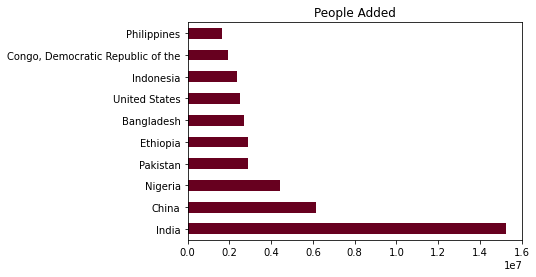

In [56]:
people_added_mod['people_added'].plot.barh(title = 'People Added',colormap=plt.cm.RdGy)
plt.ylabel('')
plt.show()

The world population growth is 1.08%, according to the population growth of the world there will be 78,370,092 more people.  India has the largest calculated value for people added at 15,270,686 with a growth rate of 1.22%.  Although South Sudan has the highest population growth rate, the country does not have a large population therefore the total number of people predicted to contribute to the population is only 484,125.

In [61]:
%%sql death_rate <<
SELECT name, population, population_growth, 
ROUND(((population_growth/100)*population),0) as people_added,
death_rate, migration_rate 
FROM facts
ORDER BY death_rate
DESC
LIMIT 10;

 * sqlite:///factbook.db
Done.
Returning data to local variable death_rate


In [62]:
%%sql migration_rate <<
SELECT name, population, population_growth, 
ROUND(((population_growth/100)*population),0) as people_added,
death_rate, migration_rate 
FROM facts
ORDER BY migration_rate
DESC
LIMIT 10;

 * sqlite:///factbook.db
Done.
Returning data to local variable migration_rate


In [63]:
death_rate = death_rate.DataFrame()
migration_rate = migration_rate.DataFrame()

In [68]:
death_rate.head()

,name,population,population_growth,people_added,death_rate,migration_rate
0,Lesotho,1947701,0.32,6233.0,14.89,7.36
1,Ukraine,44429471,0.60,266577.0,14.46,2.25
2,Bulgaria,7186893,0.58,41684.0,14.44,0.29
3,Guinea-Bissau,1726170,1.91,32970.0,14.33,0.00
4,Latvia,1986705,1.06,21059.0,14.31,6.26


In [67]:
migration_rate.head()

,name,population,population_growth,people_added,death_rate,migration_rate
0,Qatar,2194817,3.07,67381.0,1.53,22.39
1,American Samoa,54343,0.30,163.0,4.75,21.13
2,"Micronesia, Federated States of",105216,0.46,484.0,4.23,20.93
3,Syria,17064854,0.16,27304.0,4.00,19.79
4,Tonga,106501,0.03,32.0,4.85,17.84


In [69]:
death_rate.set_index('name', drop=True, inplace=True)
migration_rate.set_index('name',drop=True, inplace=True)

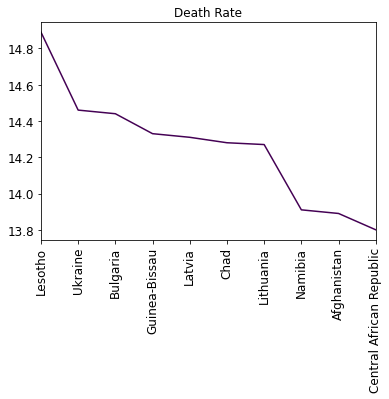

In [74]:
death_rate['death_rate'].plot(title = 'Death Rate',colormap=plt.cm.viridis,rot=90,fontsize=12)
plt.xlabel('')
plt.show()

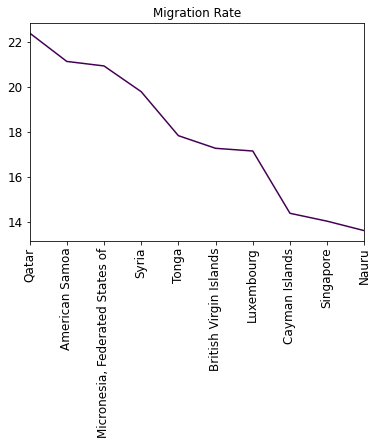

In [75]:
migration_rate['migration_rate'].plot(title = 'Migration Rate',colormap=plt.cm.viridis,rot=90,fontsize=12)
plt.xlabel('')
plt.show()

There are seven countries with a death rate over 14% with Lesotho, Ukraine, and Bulgaria as the top three.  The migration rate for Qatar, American Samoa, and Federated States of Micronesia is over 20%.

##### Death Rate over Birth Rate

In [128]:
%%sql
SELECT name, population, population_growth, 
death_rate, birth_rate, migration_rate 
FROM facts
WHERE death_rate > birth_rate
ORDER BY death_rate
DESC
LIMIT 10
;

 * sqlite:///factbook.db
Done.


name,population,population_growth,death_rate,birth_rate,migration_rate
Ukraine,44429471,0.6,14.46,10.72,2.25
Bulgaria,7186893,0.58,14.44,8.92,0.29
Latvia,1986705,1.06,14.31,10.0,6.26
Lithuania,2884433,1.04,14.27,10.1,6.27
Russia,142423773,0.04,13.69,11.6,1.69
Serbia,7176794,0.46,13.66,9.08,0.0
Belarus,9589689,0.2,13.36,10.7,0.7
Hungary,9897541,0.22,12.73,9.16,1.33
Moldova,3546847,1.03,12.59,12.0,9.67
Estonia,1265420,0.55,12.4,10.51,3.6


In [130]:
%%sql
SELECT COUNT(name) as higher_death_rate
FROM facts
WHERE death_rate>birth_rate
;

 * sqlite:///factbook.db
Done.


higher_death_rate
24


There are 24 countries with a higher death rate than birth rate.  